### <font color='blue'> DAC to audio 
</font>

This notebook reads a DAC file and uses the descript 44.1kHz pretrained DAC to decompress it to audio.   
It is in a separate file from the transformer generative code because it takes up too much memory (which doesn't seem right).  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import time

# and for creating a custom dataset and loader:
from torch.utils.data import Dataset, DataLoader
import os
import dac

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd

In [2]:
import ipywidgets as widgets
from IPython.display import display

In [3]:
import gc 
# Function to find all tensors on CUDA
def get_cuda_tensors():
    cuda_tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                cuda_tensors.append((type(obj), obj.size()))
        except Exception as e:
            pass
    return cuda_tensors

### <font color='blue'> Parameters 
</font>

In [4]:
# Training data dir
#experiment_name='experiment_onesnd_small' 

cptnum=300
tstsnd='bees'
experiment_name='newscratchbeescond8'


#must match a specific dac file name used
minpval=0
maxpval=1
inference_steps=86*20

#fname=tstsnd+'.e248.l4.h8_chkpt_'+str(cptnum).zfill(4)
fname=tstsnd+'.e248.l4.h8_chkpt_' + str(cptnum).zfill(4) + "_steps_"+str(inference_steps).zfill(4)+'.minpval_'+ f"{minpval:01.2f}" +'.maxpval_'+ f"{maxpval:01.2f}"

SAVEWAV=False
# --------------------------------------------------------------------------

# I am having with running out of memory loading the DAC model with cuda. CPU runs pretty fast
# for decompressing, so there ya go. 
DEVICE='cpu'

# --------  derived ------ don't change these 
data_dir= 'runs' + '/' + experiment_name
selected_file=data_dir+'/' + "dacs" + '/' + fname + ".dac"

print(f' fname is {fname}')

 fname is bees.e248.l4.h8_chkpt_0300_steps_1720.minpval_0.00.maxpval_1.00


In [5]:
torch.cuda.device_count()
torch.cuda.get_device_properties(0).total_memory/1e9

device = torch.device(DEVICE) # if the docker was started with --gpus all, then can choose here with cuda:0 (or cpu)
torch.cuda.device_count()
print(f'memeory on cuda 0 is  {torch.cuda.get_device_properties(0).total_memory/1e9}')

device

memeory on cuda 0 is  25.216745472


device(type='cpu')

### <font color='blue'> Get the DAC model 
that will be need *after* we run the transformer in order to reconstruct the signal from codes.
</font>

In [6]:
# The first time you do this, it can take a while. Go get coffee. After that, it uses a cached version
dacmodel_path = dac.utils.download(model_type="44khz") 

with torch.no_grad():
    dacmodel = dac.DAC.load(dacmodel_path)

    dacmodel.to(device); #wanna see the model? remove the semicolon
    dacmodel.eval();  # need to be "in eval mode" in order to set the number of quantizers

/opt/conda/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [7]:
# I'd like to have the user choose files from a dropdown list, but I think I have to 
#     add nbextensions to jupyter lab, and don't have permissions to do that.


# files = os.listdir(data_dir)

# # Create a dropdown widget
# file_dropdown = widgets.Dropdown(
#     options=files,
#     description='Files:',
# )

# # Display the dropdown
# display(file_dropdown)

# # Define a global variable to store the selected file
# selected_file = None

# # Function to handle the selection
# def on_file_change(change):
#     global selected_file_global
#     selected_file_global = change['new']
#     print(f'You selected: {selected_file}')
   
# # Attach the handler to the dropdown
# file_dropdown.observe(on_file_change, names='value')



### <font color='blue'> Codes-2-Audio reconstruction
that will be need *after* we run the transformer in order to reconstruct the signal from codes.
</font>

In [8]:
with torch.no_grad():
    dacfile = dac.DACFile.load(selected_file)
    # FIRST - Decompress it back to an AudioSignal\ from codes to z (1024) to signal   
    print(f'dacfile.codes shape is: {dacfile.codes.shape}')
    t0=time.time()
    asig=dacmodel.decompress(dacfile)
    t1=time.time()
    
inf_time = t1-t0
print(f'decompress time for {asig.audio_data.shape[2]/44100} seconds of sound is {inf_time}' )


dacfile.codes shape is: torch.Size([1, 4, 1720])
decompress time for 19.969160997732427 seconds of sound is 6.863758563995361


In [9]:
asig.audio_data.shape[2]

880640


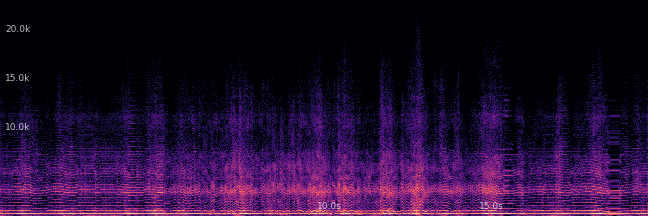
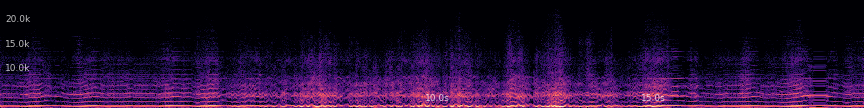

torch.Size([1, 1, 880640])

In [10]:
asig.cpu().widget()
asig.audio_data.shape

In [11]:

adata = asig.samples.view(-1).numpy()
if SAVEWAV :  
    sf.write(data_dir+'/' + "dac2wav" + '/' + fname + ".wav", adata, 44100)


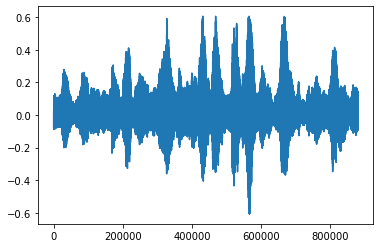

In [12]:
plt.plot(adata)
ipd.Audio(adata, rate=44100)

In [13]:
# This will list every variable on cuda if you are using it. 
cuda_tensors = get_cuda_tensors()
for tensor_type, tensor_size in cuda_tensors:
    print(f'Type: {tensor_type}, Size: {tensor_size}')

/opt/conda/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:366: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
